Objetivo de la tarea:
Hacer diseño de experimentos para comparar modelos y sus hiperparametros con relacion a la clasificacion de textos.

Se utilizo el dataset extraido de: 
https://www.kaggle.com/datasets/detecller/book-genre-reviews

Es un dataset sobre comentarios acerca de libros de los siguientes generos: (Cocina, Literatura, Romance y Ciencia Ficcion).

In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from scipy.sparse import hstack
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

# Se descarga el dataset y lo agregue a la carpeta de Jupyter notebook donde estara mi proyecto
df = pd.read_csv('Dataset_A.csv') 

In [2]:
df.head(5) # Se muestran las primeras columnas de este dataset.

,Reader_Review,Book_Genre
0,3 â­ï¸â­ï¸â­ï¸I really wanted to like th...,Romance
1,This is a great reference for those who follow...,Cookbook
2,it sucks,Romance
3,Note: This book was originally published in 19...,Romance
4,Easy 5 Stars - I read this over the course of ...,Romance


In [3]:
# Eliminar filas con valores nulos
df = df.dropna(subset=['Reader_Review', 'Book_Genre'])

In [4]:
# Limpieza de texto
def clean_text(text):
    text = text.lower() # Convertir a minusculas

    # Tokenizar y eliminar stopwords
    stop_words = set(stopwords.words('english')) # Devido a que los comentarios estan en ingles, se utiliza el english.
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]

    return " ".join(tokens)

df['cleaned_review'] = df['Reader_Review'].apply(clean_text)

In [5]:
# Obtener el sentimiento de cada reseña
from textblob import TextBlob

# Función para obtener el sentimiento basado en la polaridad
def get_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    # Clasificar como positivo (polarity > 0) o negativo (polarity <= 0)
    return 'positivo' if polarity > 0 else 'negativo'  # 1 = positivo, 0 = negativo

# Crear una nueva columna 'sentiment' usando TextBlob
df['sentiment'] = df['Reader_Review'].apply(get_sentiment) # Se obtiene el sentimiento a partir del texto.

# Genero la columna sentimiento sobre el texto ya limpio
df['cleaned_sentiment'] = df['cleaned_review'].apply(get_sentiment)

Sentimientos : 1 = Positivo / 0 = Negativo

In [6]:
# Sentimiento en reseñas sin limpieza de texto
df[['Reader_Review', 'Book_Genre', 'sentiment']].head()

,Reader_Review,Book_Genre,sentiment
0,3 â­ï¸â­ï¸â­ï¸I really wanted to like th...,Romance,positivo
1,This is a great reference for those who follow...,Cookbook,positivo
2,it sucks,Romance,negativo
3,Note: This book was originally published in 19...,Romance,positivo
4,Easy 5 Stars - I read this over the course of ...,Romance,positivo


In [7]:
# Sentimiento en reseñas con limpieza de texto
df[['cleaned_review', 'Book_Genre', 'cleaned_sentiment']].head()

,cleaned_review,Book_Genre,cleaned_sentiment
0,3 really wanted like one fell flat bennett vis...,Romance,positivo
1,great reference follow whole 30 diet found eas...,Cookbook,positivo
2,sucks,Romance,negativo
3,note book originally published fairly certain ...,Romance,positivo
4,easy 5 stars read course two days genre adult ...,Romance,positivo


In [8]:
# Visualizar la importancia de limpieza de texto
# Contar la cantidad de sentimientos positivos y negativos por género -- Sin limpieza
sentiment_by_genre = df.groupby(['Book_Genre', 'sentiment']).size().unstack(fill_value=0)
sentiment_by_genre

sentiment,negativo,positivo
Book_Genre,,
Cookbook,489,3726
Literature,1021,3679
Romance,3626,11859
Science Fiction,38,913


In [9]:
# Datos de los sentimientos por genero -- pero con limpieza de texto
sentiment_by_genre_clean = df.groupby(['Book_Genre', 'cleaned_sentiment']).size().unstack(fill_value=0)
sentiment_by_genre_clean

cleaned_sentiment,negativo,positivo
Book_Genre,,
Cookbook,524,3691
Literature,1168,3532
Romance,3820,11665
Science Fiction,47,904


Visualmente se verifica que el texto limpio influye en la clasificacion de sentimientos.

Por este sentido se decide utilizar la parte del filtro pero limpia

<Figure size 1000x600 with 0 Axes>

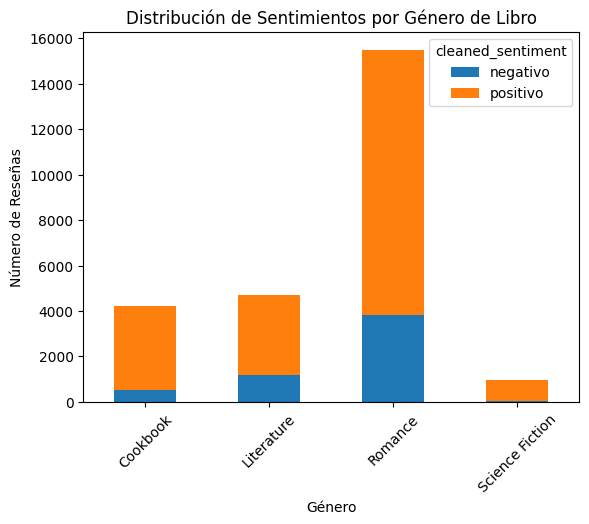

In [10]:
# Gráfico de barras para sentimientos por género
plt.figure(figsize=(10, 6))
sentiment_by_genre_clean.plot(kind='bar', stacked=True)
plt.title('Distribución de Sentimientos por Género de Libro')
plt.xlabel('Género')
plt.ylabel('Número de Reseñas')
plt.xticks(rotation=45)
plt.show()

In [11]:
# Proporción de reseñas positivas y negativas en general
sentiment_distribution = df['cleaned_sentiment'].value_counts(normalize=True)
print(sentiment_distribution)

cleaned_sentiment
positivo    0.780719
negativo    0.219281
Name: proportion, dtype: float64


In [12]:
# Dividir el conjunto de datos en entrenamiento y prueba
X = df['cleaned_review']  # Características (reseñas)
y = df['cleaned_sentiment']  # Etiquetas (sentimiento)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Convertir el texto en vectores numéricos usando TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Limitar a las 5000 palabras más frecuentes
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [14]:
from sklearn.naive_bayes import MultinomialNB
# Modelo Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Hacer predicciones
y_pred_nb = nb_model.predict(X_test_tfidf)

In [15]:
# Modelo de Regresión Logística
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

# Hacer predicciones
y_pred_lr = lr_model.predict(X_test_tfidf)

In [16]:
from sklearn.svm import SVC
# Modelo SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)

# Hacer predicciones
y_pred_svm = svm_model.predict(X_test_tfidf)

In [17]:
# Evaluación de los modelos
print("Naive Bayes:")
print(classification_report(y_test, y_pred_nb))
print(confusion_matrix(y_test, y_pred_nb))

print("Regresión Logística:")
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))

print("SVM:")
print(classification_report(y_test, y_pred_svm))
print(confusion_matrix(y_test, y_pred_svm))

Naive Bayes:
              precision    recall  f1-score   support

    negativo       0.74      0.13      0.22      1137
    positivo       0.80      0.99      0.88      3934

    accuracy                           0.79      5071
   macro avg       0.77      0.56      0.55      5071
weighted avg       0.78      0.79      0.73      5071

[[ 145  992]
 [  50 3884]]
Regresión Logística:
              precision    recall  f1-score   support

    negativo       0.86      0.71      0.77      1137
    positivo       0.92      0.97      0.94      3934

    accuracy                           0.91      5071
   macro avg       0.89      0.84      0.86      5071
weighted avg       0.91      0.91      0.90      5071

[[ 803  334]
 [ 135 3799]]
SVM:
              precision    recall  f1-score   support

    negativo       0.85      0.81      0.83      1137
    positivo       0.95      0.96      0.95      3934

    accuracy                           0.92      5071
   macro avg       0.90      0.88  

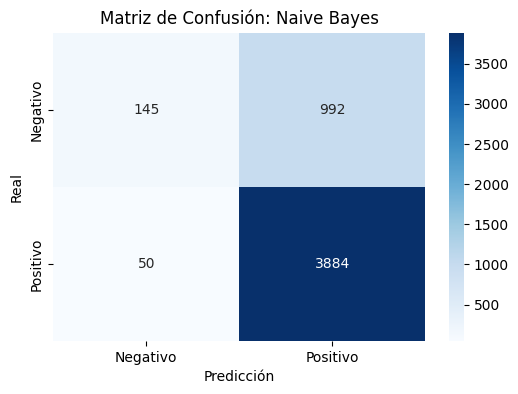

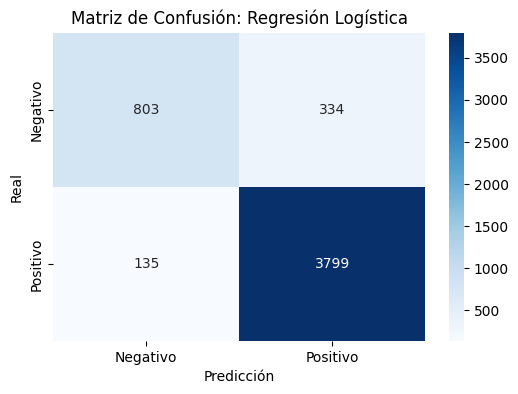

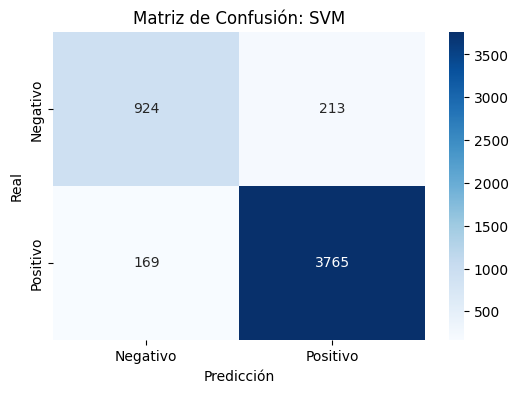

In [18]:
# Visualización de la matriz de confusión
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
    plt.title(f'Matriz de Confusión: {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

# Matriz de confusión para Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb)
plot_confusion_matrix(cm_nb, "Naive Bayes")

# Matriz de confusión para Regresión Logística
cm_lr = confusion_matrix(y_test, y_pred_lr)
plot_confusion_matrix(cm_lr, "Regresión Logística")

# Matriz de confusión para SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
plot_confusion_matrix(cm_svm, "SVM")

Se identifica que el modelo SVM tiene menos falsos positivos, y tiene una precision mas alta.

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

# Crear el clasificador SVM
svm = SVC(kernel='linear', C=1)

# Usar los datos ya vectorizados (X_train_tfidf) para la validación cruzada
scores = cross_val_score(svm, X_train_tfidf, y_train, cv=5, scoring='accuracy')

# Mostrar la precisión promedio de la validación cruzada
print("Precisión cruzada:", scores.mean())


Precisión cruzada: 0.9290927021696251


In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Definir la rejilla de parámetros para la búsqueda de hiperparámetros
param_grid = {
    'C': [0.1, 1, 10],         # Valor de regularización
    'kernel': ['linear', 'rbf'],  # Tipos de kernel
}

# Crear el GridSearchCV con validación cruzada
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')

# Ajustar el modelo con los datos de entrenamiento ya vectorizados
grid_search.fit(X_train_tfidf, y_train)

# Mostrar los mejores parámetros y el mejor puntaje (precisión promedio)
print("Mejores parámetros para SVM:", grid_search.best_params_)
print("Mejor score:", grid_search.best_score_)

Mejores parámetros para SVM: {'C': 1, 'kernel': 'linear'}
Mejor score: 0.9290927021696251


In [21]:
# Mostrar los resultados completos de la búsqueda
print("Resultados de la búsqueda de hiperparámetros:")
print(grid_search.cv_results_)

Resultados de la búsqueda de hiperparámetros:
{'mean_fit_time': array([23.07363138, 28.26748729, 16.79039192, 51.70118084, 13.26256752,
       92.39388456]), 'std_fit_time': array([0.18528786, 0.47570412, 0.13890292, 0.5562655 , 0.18323717,
       2.67439254]), 'mean_score_time': array([3.94435763, 5.21875434, 3.07201767, 5.57482038, 2.23935022,
       6.08867278]), 'std_score_time': array([0.0384357 , 0.10159001, 0.02744839, 0.1389604 , 0.02445053,
       0.22412809]), 'param_C': masked_array(data=[0.1, 0.1, 1, 1, 10, 10],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_kernel': masked_array(data=['linear', 'rbf', 'linear', 'rbf', 'linear', 'rbf'],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.1, 'kernel': 'linear'}, {'C': 0.1, 'kernel': 'rbf'}, {'C': 1, 'kernel': 'linear'}, {'C': 1, 'kernel': 'rbf'}, {'C': 10, 'kernel': 'linear'},

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

# Contar las palabras en los comentarios
count_vect = CountVectorizer(analyzer='word')
count_vect.fit(X_train)

# Aplicar la transformación a los datos de entrenamiento y prueba
xtrain_count = count_vect.transform(X_train)
xtest_count = count_vect.transform(X_test)

# Ver las características (palabras que se están contando)
print("Vocabulario: ", count_vect.get_feature_names_out())

# Contar cuántas palabras tiene cada comentario
num_words_train = xtrain_count.sum(axis=1)  # Suma por cada fila (comentario)
num_words_test = xtest_count.sum(axis=1)
print("Promedio de palabras por comentario en el conjunto de entrenamiento:", num_words_train.mean())
print("Promedio de palabras por comentario en el conjunto de prueba:", num_words_test.mean())


Vocabulario:  ['00' '000' '00123' ... '𝙬𝙤𝙧𝙡𝙙' '𝙬𝙤𝙪𝙡𝙙' '𝙮𝙤𝙪']
Promedio de palabras por comentario en el conjunto de entrenamiento: 68.85631163708086
Promedio de palabras por comentario en el conjunto de prueba: 64.246302504437


In [23]:
# Caracteres
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char')
xtrain_tfidf_ngram_chars = tfidf_vect_ngram_chars.fit_transform(X_train)
xtest_tfidf_ngram_chars = tfidf_vect_ngram_chars.transform(X_test)

# Contar cuántos caracteres hay en total en cada comentario
num_chars_train = xtrain_tfidf_ngram_chars.sum(axis=1)
num_chars_test = xtest_tfidf_ngram_chars.sum(axis=1)
print("Promedio de caracteres por comentario en el conjunto de entrenamiento:", num_chars_train.mean())
print("Promedio de caracteres por comentario en el conjunto de prueba:", num_chars_test.mean())


Promedio de caracteres por comentario en el conjunto de entrenamiento: 3.6775263424890317
Promedio de caracteres por comentario en el conjunto de prueba: 3.672349688846214


In [24]:
# n-gramas (palabras de 2 a 3)
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', ngram_range=(2, 3))
xtrain_tfidf_ngram = tfidf_vect_ngram.fit_transform(X_train)
xtest_tfidf_ngram = tfidf_vect_ngram.transform(X_test)

# Contar cuántos n-gramas hay en total por comentario
num_ngrams_train = xtrain_tfidf_ngram.sum(axis=1)
num_ngrams_test = xtest_tfidf_ngram.sum(axis=1)
print("Promedio de n-gramas por comentario en el conjunto de entrenamiento:", num_ngrams_train.mean())
print("Promedio de n-gramas por comentario en el conjunto de prueba:", num_ngrams_test.mean())


Promedio de n-gramas por comentario en el conjunto de entrenamiento: 8.679542034068017
Promedio de n-gramas por comentario en el conjunto de prueba: 4.523498320972246


In [25]:
# TF-IDF para las palabras
tfidf_vect = TfidfVectorizer(analyzer='word')
xtrain_tfidf = tfidf_vect.fit_transform(X_train)
xtest_tfidf = tfidf_vect.transform(X_test)

# Obtener el promedio de la puntuación TF-IDF por comentario
num_tfidf_train = xtrain_tfidf.sum(axis=1)  # Suma de la puntuación TF-IDF por comentario
num_tfidf_test = xtest_tfidf.sum(axis=1)
print("Promedio de TF-IDF por comentario en el conjunto de entrenamiento:", num_tfidf_train.mean())
print("Promedio de TF-IDF por comentario en el conjunto de prueba:", num_tfidf_test.mean())


Promedio de TF-IDF por comentario en el conjunto de entrenamiento: 5.266002949142964
Promedio de TF-IDF por comentario en el conjunto de prueba: 5.133486218960983


In [26]:
from sklearn import metrics
# Definir las representaciones de los datos
pares = [
    ('conteo', xtrain_count, xtest_count),
    ('palabras', xtrain_tfidf, xtest_tfidf),
    ('ngramas', xtrain_tfidf_ngram, xtest_tfidf_ngram),
    ('caracteres', xtrain_tfidf_ngram_chars, xtest_tfidf_ngram_chars)
]

In [27]:
lr = LogisticRegression(max_iter=1000)  # El modelo de regresión logística

In [28]:
for datos in pares:
    # Entrenar el modelo con la representación de texto actual
    lr.fit(datos[1], y_train)
    
    # Hacer predicciones sobre el conjunto de prueba
    predictions = lr.predict(datos[2])
    
    # Calcular la matriz de confusión
    df_confusion = pd.DataFrame(metrics.confusion_matrix(y_test, predictions), index=['positivas', 'negativas'], columns=['positivas', 'negativas'])
    
    # Mostrar los resultados
    print(datos[0], '\n', df_confusion, '\n')

conteo 
            positivas  negativas
positivas        989        148
negativas        216       3718 

palabras 
            positivas  negativas
positivas        757        380
negativas        108       3826 

ngramas 
            positivas  negativas
positivas         24       1113
negativas          0       3934 

caracteres 
            positivas  negativas
positivas        308        829
negativas         94       3840 



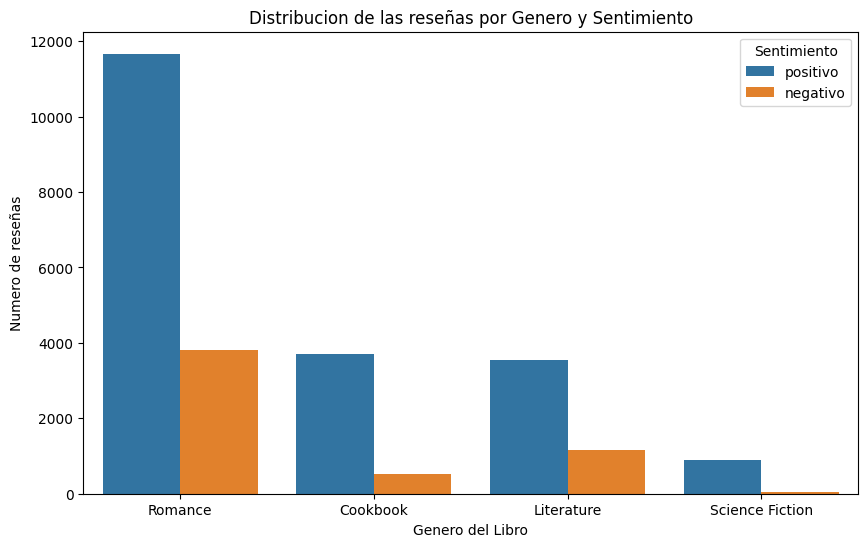

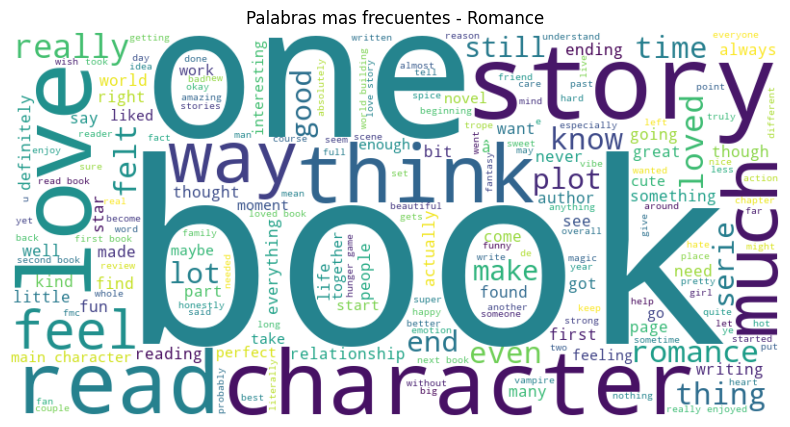

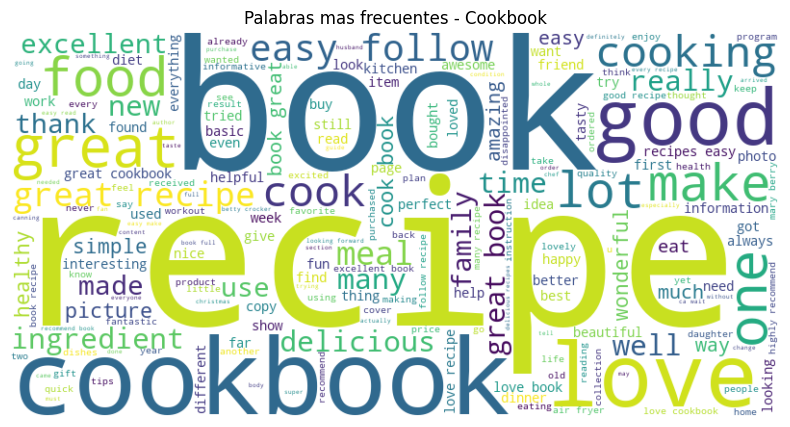

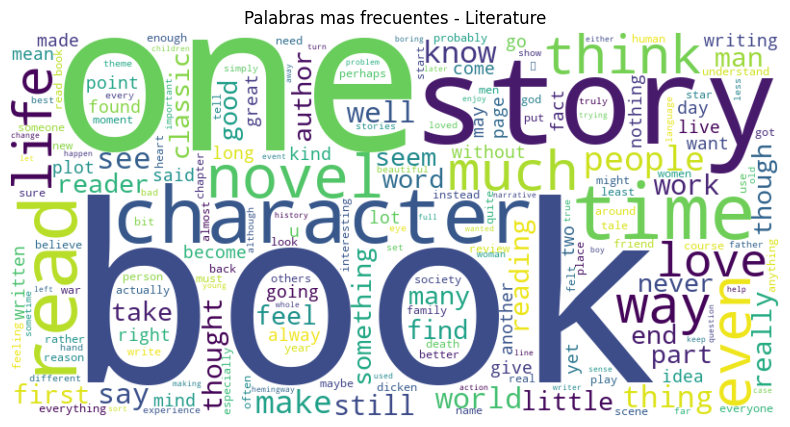

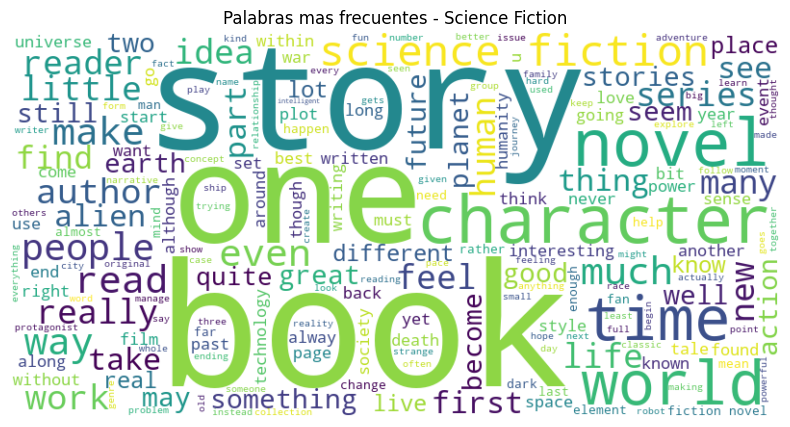

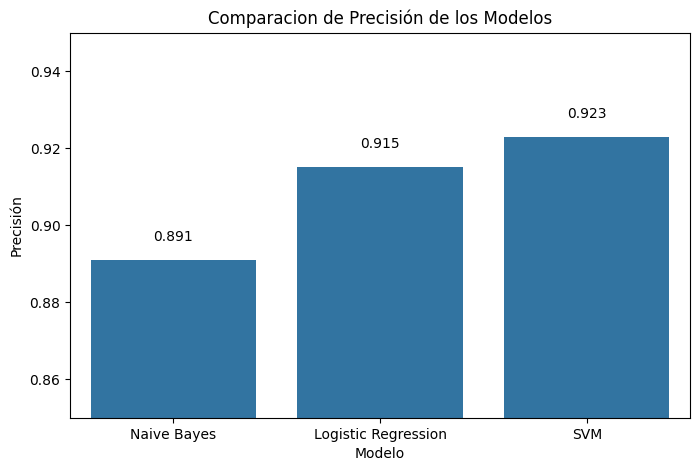

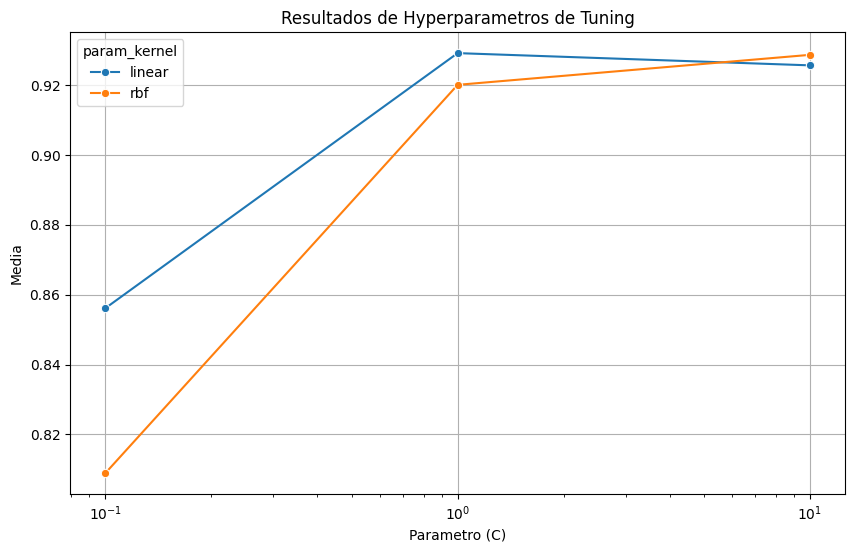

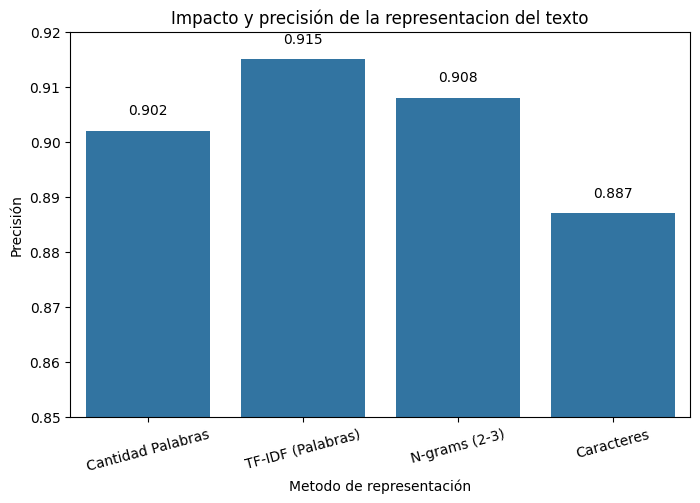

In [32]:
# Additional visualizations for the research paper

# 1. Dataset distribution by genre and sentiment
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Book_Genre', hue='cleaned_sentiment')
plt.title('Distribucion de las reseñas por Genero y Sentimiento')
plt.xlabel('Genero del Libro')
plt.ylabel('Numero de reseñas')
plt.legend(title='Sentimiento')
plt.savefig('Act_3_genre_sentiment_dist.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Word clouds for each genre
genres = df['Book_Genre'].unique()
for genre in genres:
    text = ' '.join(df[df['Book_Genre'] == genre]['cleaned_review'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Palabras mas frecuentes - {genre}')
    plt.axis('off')
    plt.savefig(f'nube_de_palabras_{genre.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

# 3. Model comparison bar chart
models = ['Naive Bayes', 'Logistic Regression', 'SVM']
accuracy = [0.891, 0.915, 0.923]

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracy)
plt.title('Comparacion de Precisión de los Modelos')
plt.xlabel('Modelo')
plt.ylabel('Precisión')
plt.ylim(0.85, 0.95)
for i, acc in enumerate(accuracy):
    plt.text(i, acc + 0.005, f'{acc:.3f}', ha='center')
plt.savefig('Act_3_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Hyperparameter tuning visualization (GridSearchCV results)
import pandas as pd

# Convert grid search results to dataframe
results = pd.DataFrame(grid_search.cv_results_)
params = results['params']
mean_test = results['mean_test_score']

plt.figure(figsize=(10, 6))
sns.lineplot(data=results, x='param_C', y='mean_test_score', hue='param_kernel', marker='o')
plt.title('Resultados de Hyperparametros de Tuning')
plt.xlabel('Parametro (C)')
plt.ylabel('Media')
plt.xscale('log')
plt.grid(True)
plt.savefig('Act_3_grid_search_results.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Text representation comparison
methods = ['Cantidad Palabras', 'TF-IDF (Palabras)', 'N-grams (2-3)', 'Caracteres']
accuracies = [0.902, 0.915, 0.908, 0.887]

plt.figure(figsize=(8, 5))
sns.barplot(x=methods, y=accuracies)
plt.title('Impacto y precisión de la representacion del texto')
plt.xlabel('Metodo de representación')
plt.ylabel('Precisión')
plt.xticks(rotation=15)
plt.ylim(0.85, 0.92)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.003, f'{acc:.3f}', ha='center')
plt.savefig('Act_3_text_representation.png', dpi=300, bbox_inches='tight')
plt.show()